In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

from pathlib import Path

from sklearn.preprocessing import StandardScaler, PowerTransformer, \
    RobustScaler, OneHotEncoder
from tqdm import tqdm
import joblib

pd.set_option('display.float_format', '{:.8f}'.format)

In [2]:
DATASET_PATH = Path(r"E:\gnn_data\pyg_data_v2")
DATASET_PATH_SCALED = Path(r"E:\gnn_data\pyg_data_v2_scaled")
DATASET_PATH_SCALED.mkdir(exist_ok=True)

In [57]:
# Concat tensor to scale features
all_node_features = []
all_edge_features = []
all_global_features = []
all_files = list(Path(DATASET_PATH).glob("*.pt"))
for file in tqdm(all_files):
    try:
        data = torch.load(file, weights_only=False)
        if data.x is not None:
            all_node_features.append(data.x.numpy())
        if data.edge_attr is not None:
            all_edge_features.append(data.edge_attr.numpy())
        if data.global_features is not None:
            all_global_features.append(data.global_features.numpy())
    except Exception as e:
        print(f"Error loading {file}: {e}")
        continue

100%|██████████| 62198/62198 [06:47<00:00, 152.62it/s]


In [58]:
concatenated_node_features = np.vstack(all_node_features)
concatenated_edge_features = np.vstack(all_edge_features)
concatenated_global_features = np.vstack(all_global_features)
edge_df = pd.DataFrame(concatenated_edge_features)
node_df = pd.DataFrame(concatenated_node_features)
global_df = pd.DataFrame(concatenated_global_features)
len(concatenated_node_features), len(concatenated_edge_features), len(
    concatenated_global_features)

(7207663, 35437906, 62198)

In [59]:
node_columns = [
    "item_id", 'node_degree', 'degree_centrality', 'average_neighbor_degree',
    'triangles', 'page_rank',
    'betweenness_centrality', 'closeness_centrality',
    'clustering_coefficient',
    'area', 'perimeter', 'edge_count', 'vertex_count',
    'compactness', 'u_span', 'v_span', 'mean_curvature',
    'orientation', 'surface_type',
]

node_columns = node_columns[:5] + node_columns[9:17] + node_columns[5:9] + node_columns[17:]

node_df.columns = node_columns
node_df.describe()

,item_id,node_degree,degree_centrality,average_neighbor_degree,triangles,area,perimeter,edge_count,vertex_count,compactness,u_span,v_span,mean_curvature,page_rank,betweenness_centrality,closeness_centrality,clustering_coefficient,orientation,surface_type
count,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000
mean,73581.39843750,4.91670036,0.04149254,40.93860245,3.43363309,826.40307617,93.14465332,5.09715176,4.98209858,0.46362433,12.68271065,18.15581131,-0.23450254,0.00862942,0.02025690,0.26754567,0.40480793,0.55952114,1.49751234
std,29072.43945312,11.80577755,0.08558629,94.13003540,10.66164970,14092.12109375,331.69641113,12.01191139,12.02399921,0.30184901,57.45454788,79.25156403,0.68544483,0.01742876,0.06342044,0.13665757,0.26747343,0.51759177,1.97586739
min,23481.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00011846,1.00000000,1.00000000,0.00000000,0.00000000,0.00000000,-10.00000000,0.00006381,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
25%,48870.00000000,4.00000000,0.00535332,4.75000000,1.00000000,2.69648170,9.33497810,4.00000000,4.00000000,0.20388903,1.00000000,1.00000000,-0.22222222,0.00110429,0.00017593,0.17065556,0.16666667,0.00000000,0.00000000
50%,71507.00000000,4.00000000,0.01339286,8.75000000,3.00000000,20.02379036,27.22178268,4.00000000,4.00000000,0.47086021,3.00000000,3.00000000,-0.01811594,0.00279895,0.00148221,0.25078699,0.33333334,1.00000000,1.00000000
75%,98395.00000000,4.00000000,0.03846154,28.75000000,4.00000000,112.31193542,66.00000000,4.00000000,4.00000000,0.70534748,6.28318548,11.62790966,0.00000000,0.00817791,0.00870273,0.35738832,0.66666669,1.00000000,2.00000000
max,125515.00000000,1825.00000000,2.00000000,1182.33337402,1824.00000000,2886913.00000000,50747.99218750,1825.00000000,1825.00000000,16.05916786,4446.96679688,15581.22656250,10.00000000,0.57446861,1.00000000,1.00000000,1.00000000,1.00000000,9.00000000


<Axes: >

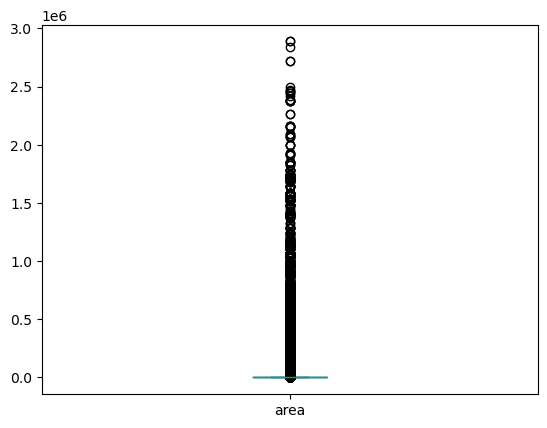

In [60]:
node_df[node_df.area > 0].area.plot(kind='box')

In [61]:
to_remove_id = node_df[(node_df.mean_curvature < -10) | (node_df.mean_curvature > 10)].item_id.values
to_remove_id = set([str(int(item)) for item in to_remove_id])
len(to_remove_id)

0

In [62]:
step_to_check = []
step_broken_dir = Path(r"E:\gnn_data\step_broken")
file_moved = 0
for file in Path(r"E:\gnn_data\step_files").glob("*.*"):
    if file.stem.split("_")[0] in to_remove_id:
        file.rename(step_broken_dir / file.name)
        file_moved += 1
print(f"Moved {file_moved} files to {step_broken_dir}")

Moved 0 files to E:\gnn_data\step_broken


In [64]:
edge_columns = [
    "shared_face_count", "curve_type", "length", "chord_length", "is_closed", "orientation",

]
edge_df.columns = edge_columns
edge_df.describe()

,shared_face_count,curve_type,length,chord_length,is_closed,orientation
count,35437906.00000000,35437906.00000000,35437906.00000000,35437906.00000000,35437906.00000000,35437906.00000000
mean,2.00036740,1.44088829,18.45617104,14.39870262,0.46545297,0.04799934
std,0.97307545,2.04126692,78.55681610,62.20270538,0.48653147,0.20872761
min,2.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
25%,2.00000000,0.00000000,1.14261234,0.77115077,0.00000000,0.00000000
50%,2.00000000,1.00000000,4.00014973,3.00000000,0.00000000,0.00000000
75%,2.00000000,1.00000000,13.13338947,9.53872967,1.00000000,0.00000000
max,4.00000000,6.00000000,24738.07617188,7083.93994141,1.00000000,1.00000000


In [42]:
global_columns = [
    "faces", "edges", "vertices", "quantity",
    "height", "width", "depth", "volume", "area",
    "bbox_height", "bbox_width", "bbox_depth", "bbox_volume",
    "bbox_area",
]
global_df.columns = global_columns
global_df.describe()

,faces,edges,vertices,quantity,height,width,depth,volume,area,bbox_height,bbox_width,bbox_depth,bbox_volume,bbox_area
count,62198.00000000,62198.00000000,62198.00000000,62198.00000000,62198.00000000,62198.00000000,62198.00000000,62198.00000000,62198.00000000,62198.00000000,62198.00000000,62198.00000000,62198.00000000,62198.00000000
mean,115.87760162,303.86050415,193.14466858,50.61309052,90.48128510,120.32733917,112.47856140,504756.40625000,92888.31250000,94.39996338,167.32948303,59.50634766,2964243.25000000,59.50634766
std,219.37226868,577.70739746,365.66427612,333.13510132,158.79827881,207.23075867,186.56289673,2791833.50000000,354723.12500000,141.77568054,262.35568237,93.30776215,42696920.00000000,93.30776215
min,2.00000000,3.00000000,2.00000000,1.00000000,0.10000000,0.10000000,0.07000000,0.00008384,0.06177394,0.07000000,0.10000000,0.10000000,0.00494200,0.10000000
25%,23.00000000,57.00000000,36.00000000,1.00000000,20.00000000,23.60000038,22.00000000,9383.05688477,6022.57519531,21.97349930,37.95422745,15.00000000,26250.00000000,15.00000000
50%,44.00000000,115.00000000,74.00000000,2.00000000,40.00000000,60.00001144,53.03080750,37802.35937500,16901.42773438,50.00000000,90.00000000,29.49941254,128697.29687500,29.49941254
75%,106.00000000,280.00000000,179.00000000,6.00000000,99.04874420,134.91200256,123.59999847,202855.60937500,61179.89843750,105.00000000,180.00000000,68.50379944,671994.07812500,68.50379944
max,2900.00000000,7778.00000000,5114.00000000,9600.00000000,3104.00000000,5110.00000000,5000.00000000,99667912.00000000,27595844.00000000,2782.26562500,6081.52636719,2369.00000000,5282931712.00000000,2369.00000000


In [43]:
std_scaler = StandardScaler()
rb_scaler = RobustScaler()
pt_scaler = PowerTransformer()

pt_node_df = pd.DataFrame(pt_scaler.fit_transform(node_df.iloc[:, 1:13]))
pt_node_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11
count,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000
mean,-0.00000002,-0.00000001,-0.00000000,0.00000004,0.00000000,-0.00000001,0.00000000,-0.00000001,0.00000001,0.00000001,0.00000001,-0.00000000
std,1.00189829,0.99553233,0.99545538,0.99967074,0.99632168,0.99554378,0.99952495,0.99901342,0.99546027,0.99488014,0.99424034,0.98431462
min,-12.80566025,-1.19939780,-4.62360620,-1.60452652,-1.61600995,-2.59231758,-6.98343420,-5.10011673,-1.77486718,-1.91054368,-1.79620552,-8.46036148
25%,0.01074957,-0.83189958,-0.82164377,-0.64952034,-0.83312541,-0.67004597,-0.09646273,0.02307780,-0.86197013,-0.74014175,-0.85472673,-0.06836542
50%,0.01074957,-0.35716188,-0.15229301,0.29607743,0.04835479,0.05807765,-0.09646273,0.02307780,0.12488431,0.12775521,-0.10508639,0.27965906
75%,0.01074957,0.67770714,0.83036113,0.59850842,0.75640059,0.64201963,-0.09646273,0.02307780,0.85474926,0.69502139,0.81680650,0.31204990
max,4.35718393,2.15358710,2.04333687,8.25516605,3.09980631,4.05105877,3.75859046,3.86764359,12.33006287,2.49697042,2.63085961,40.06744003


In [75]:
pd.concat([pt_node_df, node_df.iloc[:, 13:]], axis=1)

,0,1,2,3,4,5,6,7,8,9,10,11,page_rank,betweenness_centrality,closeness_centrality,clustering_coefficient,orientation,surface_type
0,0.01074957,-0.09217155,1.47900069,0.59850842,-0.62789369,0.07807353,-0.09646273,0.02307780,-1.44187582,-1.90216756,-1.52186084,0.31601930,0.00328070,0.00001904,0.46943232,0.66666669,0.00000000,6.00000000
1,0.01074957,-0.09217155,1.47900069,0.59850842,-0.60239458,0.11643869,-0.09646273,0.02307780,-1.45939779,-1.90216756,-1.42349875,0.32165903,0.00328070,0.00001904,0.46943232,0.66666669,0.00000000,6.00000000
2,0.01074957,-0.09217155,1.47900069,0.59850842,0.67033291,0.36803746,-0.09646273,0.02307780,0.54074013,1.38764811,0.65326768,0.31204990,0.00328070,0.00001904,0.46943232,0.66666669,0.00000000,0.00000000
3,0.01074957,-0.09217155,1.47900069,0.59850842,-0.62789369,0.07807353,-0.09646273,0.02307780,-1.44187582,-1.90216756,-1.52186084,0.31601930,0.00328070,0.00001904,0.46943232,0.66666669,0.00000000,6.00000000
4,0.01074957,-0.09217155,1.47900069,0.59850842,-0.60239458,0.11643869,-0.09646273,0.02307780,-1.45939779,-1.90216756,-1.42349875,0.32165903,0.00328070,0.00001904,0.46943232,0.66666669,0.00000000,6.00000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7207658,0.01074957,1.31087947,-1.38376331,-1.60452652,-1.20906770,-0.21732502,-1.18967378,-2.29863334,-1.60351634,-0.74014175,0.41870585,1.28850222,0.01612903,0.44808742,0.05695612,0.00000000,0.00000000,6.00000000
7207659,0.01074957,1.31087947,-1.38376331,-1.60452652,-1.20112824,-0.19053249,-1.18967378,-2.29863334,-1.61198545,-0.74014175,0.41870585,1.06718528,0.01612903,0.45901638,0.05803996,0.00000000,0.00000000,6.00000000
7207660,0.01074957,1.31087947,-1.38376331,-1.60452652,-1.17425025,-0.15946636,-1.18967378,-2.29863334,-1.61213136,-0.74014175,0.41870585,0.69745427,0.01612903,0.46885246,0.05905131,0.00000000,0.00000000,6.00000000
7207661,0.01074957,1.31087947,-1.38376331,-1.60452652,-1.08351409,-0.12141030,-0.09646273,-0.85859513,-1.58248997,-0.74014175,0.41870585,0.33272633,0.01612903,0.47759563,0.05998033,0.00000000,0.00000000,6.00000000


In [44]:
std_node_df = pd.DataFrame(std_scaler.fit_transform(node_df.iloc[:, 1:13]))
std_node_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11
count,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000
mean,-0.00000000,-0.00000001,-0.00000001,0.00000000,-0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,-0.00000000,0.00000000
std,0.99415886,0.97961468,0.97003794,0.98805135,0.99829781,0.98579013,0.99434280,0.99362504,0.99514741,0.98876035,0.98776627,0.97787118
min,-0.41418877,-0.47576094,-0.42225793,-0.31804812,-0.05854623,-0.27672857,-0.33922037,-0.32945475,-1.53066123,-0.21836865,-0.22655824,-13.93483639
25%,-0.07722382,-0.41437879,-0.37326449,-0.22542086,-0.05835520,-0.24899507,-0.09083775,-0.08125298,-0.85751969,-0.20115082,-0.21407968,0.01752322
50%,-0.07722382,-0.32219595,-0.33200687,-0.04016633,-0.05712765,-0.19585411,-0.09083775,-0.08125298,0.02388809,-0.16671513,-0.18912256,0.30877185
75%,-0.07722382,-0.03475373,-0.12571871,0.05246095,-0.05058953,-0.08064561,-0.09083775,-0.08125298,0.79804993,-0.11018577,-0.08145868,0.33462229
max,153.32606506,22.45661354,11.77281094,168.63409424,204.46392822,150.49346924,150.67739868,150.57722473,51.48882675,76.34879303,194.20468140,14.60408211


In [45]:
rb_node_df = pd.DataFrame(rb_scaler.fit_transform(node_df.iloc[:, 1:13]))
rb_node_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11
count,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000,7207663.00000000
mean,0.91669852,0.84872127,1.34119368,0.14454460,7.35643339,1.16337931,1.09715116,0.98210001,-0.01442892,1.83273900,1.42603815,-0.97373915
std,11.80754089,2.59095073,3.90798092,3.55852151,128.55349731,5.85683155,12.01363659,12.02429962,0.60182625,10.86909294,7.45040464,3.10243106
min,-4.00000000,-0.40451759,-0.36458334,-1.00000000,-0.18267307,-0.48039627,-3.00000000,-3.00000000,-0.93898153,-0.56783921,-0.28227565,-44.91847610
25%,0.00000000,-0.24282603,-0.16666667,-0.66666669,-0.15807359,-0.31565866,0.00000000,0.00000000,-0.53238940,-0.37855950,-0.18818375,-0.91847831
50%,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
75%,0.00000000,0.75717396,0.83333331,0.33333334,0.84192640,0.68434137,0.00000000,0.00000000,0.46761057,0.62144053,0.81181625,0.08152173
max,1821.00000000,60.00344086,48.89930725,607.00000000,26336.55078125,895.09838867,1821.00000000,1821.00000000,31.08593941,841.15289307,1465.78466797,45.08152008


In [66]:
edge_pt_scaler = PowerTransformer()
edge_one_hot = OneHotEncoder()
edge_df_pt_scaled = pd.DataFrame(edge_pt_scaler.fit_transform(edge_df.iloc[:, 2:5]))
edge_df_one_hot = pd.DataFrame(edge_one_hot.fit_transform(edge_df.iloc[:, 0:2]))
edge_scaled_df = pd.concat([edge_df_pt_scaled, edge_df_one_hot, edge_df.iloc[:, 4:]], axis=1)
edge_scaled_df

,0,1,2,0,is_closed,orientation
0,0.81823951,1.00712299,1.07165515,"(0, 0)\t1.0\n (0, 5)\t1.0",1.00000000,0.00000000
1,0.81823951,1.00712299,1.07165515,"(0, 0)\t1.0\n (0, 5)\t1.0",1.00000000,0.00000000
2,-1.42752099,-1.24405205,1.07165515,"(0, 0)\t1.0\n (0, 3)\t1.0",1.00000000,0.00000000
3,-1.42752099,-1.24405205,1.07165515,"(0, 0)\t1.0\n (0, 3)\t1.0",1.00000000,0.00000000
4,0.81823951,1.00712299,-0.93313593,"(0, 0)\t1.0\n (0, 5)\t1.0",0.00000000,0.00000000
...,...,...,...,...,...,...
35437901,-1.62497962,-1.45303595,-0.93313593,"(0, 0)\t1.0\n (0, 8)\t1.0",0.00000000,0.00000000
35437902,0.19521198,0.09461578,1.07165515,"(0, 0)\t1.0\n (0, 4)\t1.0",1.00000000,0.00000000
35437903,0.19521198,0.09461578,1.07165515,"(0, 0)\t1.0\n (0, 4)\t1.0",1.00000000,0.00000000
35437904,-1.20237553,-1.00767088,-0.93313593,"(0, 0)\t1.0\n (0, 3)\t1.0",0.00000000,0.00000000


In [73]:
edge_one_hot = OneHotEncoder(sparse_output=False)
edge_df_one_hot = pd.DataFrame(edge_one_hot.fit_transform(edge_df.iloc[:, 0:2]),
                              columns=edge_one_hot.get_feature_names_out(edge_df.columns[:2]))
edge_df_one_hot


,shared_face_count_2.0,shared_face_count_3.0,shared_face_count_4.0,curve_type_0.0,curve_type_1.0,curve_type_2.0,curve_type_3.0,curve_type_4.0,curve_type_6.0
0,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000
1,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000
2,1.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
3,1.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
4,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000
...,...,...,...,...,...,...,...,...,...
35437901,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000
35437902,1.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000
35437903,1.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000
35437904,1.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000


In [52]:
F.one_hot(torch.tensor(node_df.iloc[:,-1], dtype=torch.long))

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0]])

In [53]:
edge_df.describe()

,shared_face_count,length,chord_length,is_closed,orientation,curve_type
count,35437906.00000000,35437906.00000000,35437906.00000000,35437906.00000000,35437906.00000000,35437906.00000000
mean,2.00036740,18.45617104,14.39870262,0.46545297,0.04799934,1.44088829
std,0.97307545,78.55681610,62.20270538,0.48653147,0.20872761,2.04126692
min,2.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
25%,2.00000000,1.14261234,0.77115077,0.00000000,0.00000000,0.00000000
50%,2.00000000,4.00014973,3.00000000,0.00000000,0.00000000,1.00000000
75%,2.00000000,13.13338947,9.53872967,1.00000000,0.00000000,1.00000000
max,4.00000000,24738.07617188,7083.93994141,1.00000000,1.00000000,6.00000000


In [28]:
import os

with open(r"E:\gnn_data\pyg_data_v2\dataset_mapping.pkl", "rb") as f:
    dataset_mapping = joblib.load(f)

In [31]:
dataset_mapping["processed_files"] = [
    item for item in dataset_mapping["processed_files"]
    if "Outlet_Coolant" in item["original_path"]
]

{'original_path': 'E:\\gnn_data\\graphml_files\\95332_EM50_15S7P_Outlet_Coolant_Cup.graphml', 'processed_path': 'E:\\gnn_data\\pyg_data_v2\\95332_EM50_15S7P_Outlet_Coolant_Cup.pt', 'label': 1, 'index': 60185}
{'original_path': 'E:\\gnn_data\\graphml_files\\95335_EM50_15S7P_Outlet_Coolant_Cup.graphml', 'processed_path': 'E:\\gnn_data\\pyg_data_v2\\95335_EM50_15S7P_Outlet_Coolant_Cup.pt', 'label': 1, 'index': 60188}


In [11]:
unscaled = torch.load(r"E:\gnn_data\pyg_data_v2\100062_CEL_03_0089_V4_2025_01_21.pt", weights_only=False)
scaled = torch.load(r"E:\gnn_data\pyg_data_v2_scaled\100062_CEL_03_0089_V4_2025_01_21.pt", weights_only=False)

In [9]:
unscaled["y"]

tensor([1])

In [5]:
pd.DataFrame(unscaled.x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,100062.00000000,2.00000000,0.00448431,3.00000000,0.00000000,5.61216450,9.58100414,4.00000000,3.00000000,0.76827699,3.14159274,2.04160833,-0.29430747,0.00142426,0.00001041,0.14513505,0.00000000,1.00000000,2.00000000
1,100062.00000000,4.00000000,0.00896861,4.00000000,2.00000000,54.61496353,31.00917244,6.00000000,6.00000000,0.71374124,3.14159274,10.00000000,-0.28571430,0.00220838,0.00448750,0.16958176,0.33333334,1.00000000,1.00000000
2,100062.00000000,2.00000000,0.00448431,2.50000000,0.00000000,5.61216450,9.58100414,4.00000000,3.00000000,0.76827699,3.14159274,2.04160833,-0.29430747,0.00145827,0.00000504,0.14504065,0.00000000,1.00000000,2.00000000
3,100062.00000000,3.00000000,0.00672646,4.00000000,1.00000000,54.97787094,30.99557495,4.00000000,4.00000000,0.71911448,3.14159274,10.00000000,-0.28571430,0.00180408,0.00446381,0.16945289,0.33333334,1.00000000,1.00000000
4,100062.00000000,4.00000000,0.00896861,72.75000000,4.00000000,2.74889350,6.64159250,4.00000000,4.00000000,0.78311032,1.57079637,1.75000000,-0.50000000,0.00155689,0.00057012,0.33184522,0.66666669,0.00000000,1.00000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,100062.00000000,4.00000000,0.00896861,16.00000000,4.00000000,9.42477798,15.14159298,4.00000000,4.00000000,0.51657993,1.57079637,6.00000000,-0.50000000,0.00167501,0.00015388,0.20281947,0.66666669,0.00000000,1.00000000
443,100062.00000000,4.00000000,0.00896861,16.00000000,4.00000000,9.42477798,15.14159298,4.00000000,4.00000000,0.51657993,1.57079637,6.00000000,-0.50000000,0.00167501,0.00015388,0.20281947,0.66666669,0.00000000,1.00000000
444,100062.00000000,4.00000000,0.00896861,16.50000000,4.00000000,9.42477798,15.14159298,4.00000000,4.00000000,0.51657993,1.57079637,6.00000000,-0.50000000,0.00170022,0.00016463,0.20318906,0.66666669,0.00000000,1.00000000
445,100062.00000000,185.00000000,0.41479820,4.76216221,185.00000000,4909.73925781,8318.54003906,185.00000000,185.00000000,0.00089161,154.00000000,204.00000000,0.00000000,0.05984786,0.46682021,0.45837617,0.01086957,0.00000000,0.00000000


In [6]:
pd.DataFrame(scaled.x)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,-2.36917782,-0.88856727,-1.38376331,-1.60452652,-0.51935393,-0.65235418,-0.09646273,-0.85859513,1.03361976,0.16484381,...,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
1,0.01074957,-0.60774773,-1.02726340,-0.09524558,0.47311378,0.14551882,1.11332548,1.05263269,0.87898809,0.16484381,...,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
2,-2.36917782,-0.88856727,-1.61497760,-1.60452652,-0.51935393,-0.65235418,-0.09646273,-0.85859513,1.03361976,0.16484381,...,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
3,-0.90337020,-0.74459845,-1.02726340,-0.64952034,0.47580427,0.14522472,-0.09646273,0.02307780,0.89439261,0.16484381,...,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
4,0.01074957,-0.60774773,1.33431304,0.59850842,-0.82529002,-0.89990401,-0.09646273,0.02307780,1.07494235,-0.39543951,...,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,0.01074957,-0.60774773,0.39916083,0.59850842,-0.28728825,-0.34004918,-0.09646273,0.02307780,0.27586567,-0.39543951,...,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
443,0.01074957,-0.60774773,0.39916083,0.59850842,-0.28728825,-0.34004918,-0.09646273,0.02307780,0.27586567,-0.39543951,...,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
444,0.01074957,-0.60774773,0.42428070,0.59850842,-0.28728825,-0.34004918,-0.09646273,0.02307780,0.27586567,-0.39543951,...,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
445,4.18402863,2.15181351,-0.81863403,5.36783838,1.93807256,3.28344464,3.69601321,3.74662662,-1.77048659,2.10372281,...,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000


In [89]:
pd.DataFrame(unscaled.edge_attr, columns=edge_df.columns)

,shared_face_count,curve_type,length,chord_length,is_closed,orientation
0,2.00000000,1.00000000,5.49778700,3.50000000,0.00000000,0.00000000
1,2.00000000,1.00000000,5.49778700,3.50000000,0.00000000,0.00000000
2,2.00000000,0.00000000,2.04160833,2.04160833,1.00000000,0.00000000
3,2.00000000,0.00000000,2.04160833,2.04160833,1.00000000,0.00000000
4,2.00000000,0.00000000,10.00000000,10.00000000,0.00000000,0.00000000
...,...,...,...,...,...,...
2647,2.00000000,1.00000000,3.14159274,2.00000000,1.00000000,0.00000000
2648,2.00000000,1.00000000,5.49778700,3.50000000,1.00000000,0.00000000
2649,2.00000000,1.00000000,5.49778700,3.50000000,1.00000000,0.00000000
2650,2.00000000,1.00000000,5.49778700,3.50000000,1.00000000,0.00000000


In [87]:
pd.DataFrame(scaled.edge_attr)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.21500720,0.11460023,2.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
1,0.21500720,0.11460023,2.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
2,-0.47929421,-0.26307076,2.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000
3,-0.47929421,-0.26307076,2.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000
4,0.61907071,0.81861818,2.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2647,-0.17958987,-0.27722991,2.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000
2648,0.21500720,0.11460023,2.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000
2649,0.21500720,0.11460023,2.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000
2650,0.21500720,0.11460023,2.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000


In [90]:
pd.DataFrame(unscaled.global_features)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,447.00000000,1368.00000000,904.00000000,10.00000000,230.00056458,175.00056458,9.50056076,130892.10156250,83646.10156250,9.50056076,175.00056458,230.00056458,382399.71875000,230.00056458


In [91]:
pd.DataFrame(scaled.global_features)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.50939655,1.84195864,1.94404793,-0.12192649,0.87862372,0.26382789,-0.55197787,-0.13390332,-0.02605509,-0.59879136,0.02923957,1.82732224,-0.06047219,1.82732224


In [5]:
sync_dataset = pd.read_csv(r".\data\synced_dataset_final.csv")

In [23]:
import shutil
old_pt_dir = Path(r"E:\gnn_data\pyg_data_v2_scaled")
for index, row in tqdm(sync_dataset.iterrows()):
    file_path = Path(row["step_file"])
    fold_id = int(row["binary_fold"])
    new_pt_dir = old_pt_dir / f"fold_{str(fold_id).zfill(2)}"
    new_pt_dir.mkdir(exist_ok=True, parents=True)
    old_pt_path = old_pt_dir / file_path.with_suffix(".pt").name
    new_pt_path = new_pt_dir / file_path.with_suffix(".pt").name
    shutil.copy(old_pt_path, new_pt_path)

62198it [09:40, 107.13it/s]
